# Data exploration

In [403]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
%matplotlib inline

# Read in data.
df = pd.read_csv("UsArrests.csv", index_col = 'City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [404]:
# Print the shape of the data.
print(f'Number of cases: {df.shape[0]} Number of features: {df.shape[1]}')

Number of cases: 50 Number of features: 4


The data consists of information about violent crime for each of the 50 continental US states. It has 50 rows, one per state, and 4 variables for each row. The variables measure rates of violent crime (murder, assault and rape) per 100,000 people and urban population level. 

In [405]:
# View statistical properties of columns. 
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


Each variable has very different mean, std deviation, min and max. This highlights the need for each variable to be standardised so that the components with higher variance do not dominate the Principal Components Analysis. 

In [406]:
# Count missing values.
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing


,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


There is no missing data so no need for removal or imputation.

In [407]:
# Examine types of data.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


Data is all either int or float, allowing for numerical analysis without conversion. 

# Initial visualisation of data

Text(0.5, 1.0, 'Rape Rate Histogram')

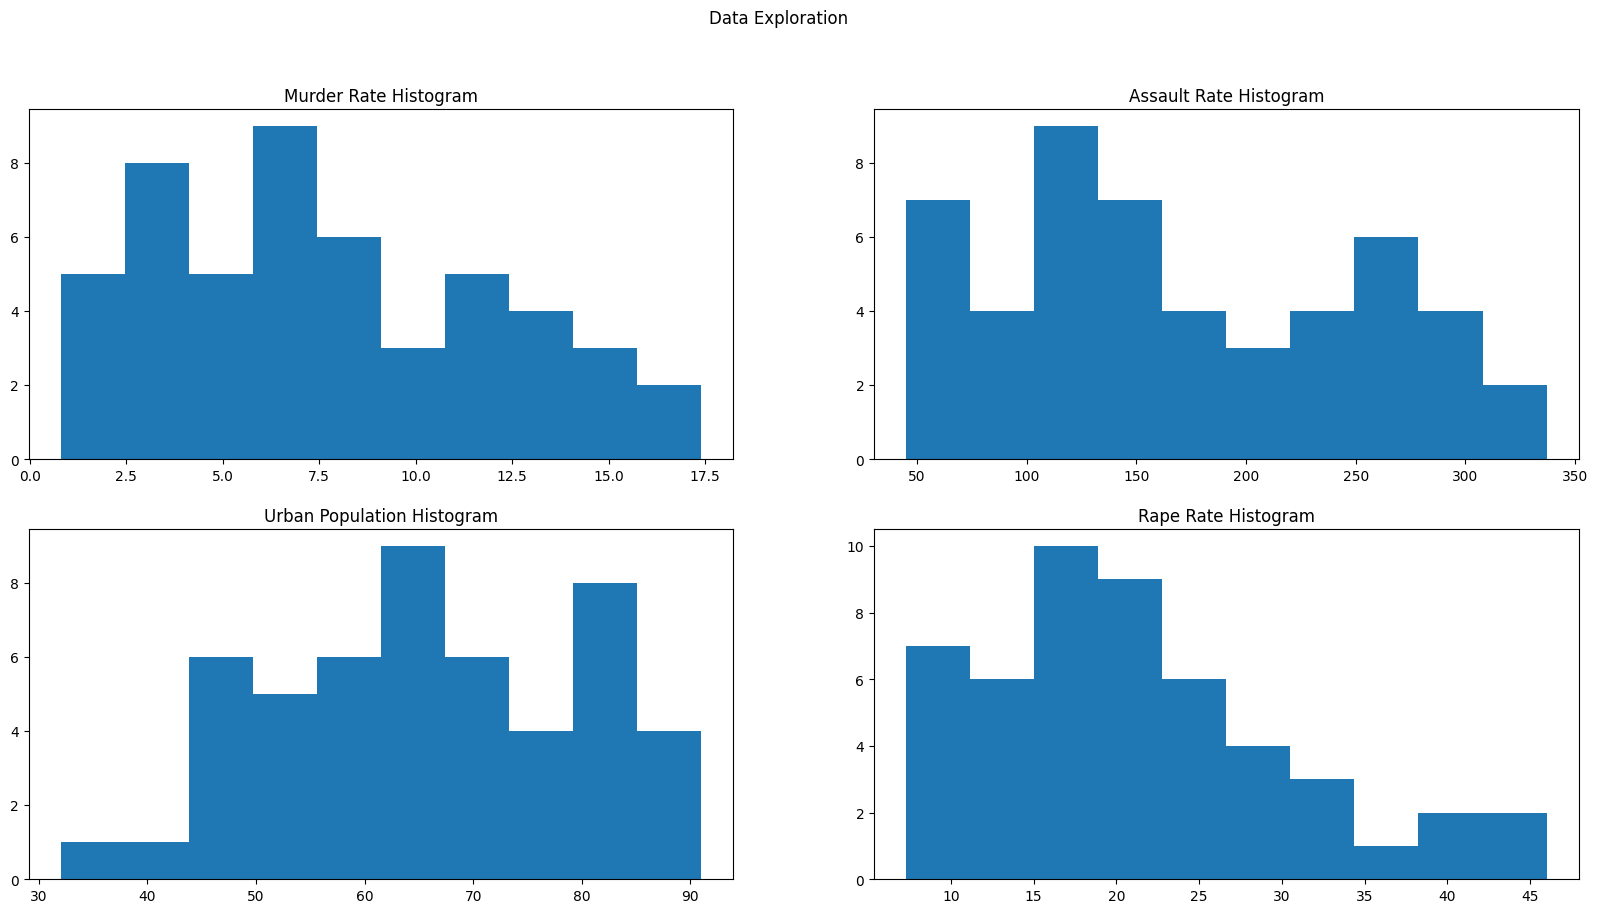

In [408]:
# Create histograms for each variable.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('Data Exploration')
fig.set_size_inches(20,10)

ax1.hist(df['Murder'])
ax1.set_title("Murder Rate Histogram")

ax2.hist(df['Assault'])
ax2.set_title("Assault Rate Histogram")

ax3.hist(df['UrbanPop'])
ax3.set_title("Urban Population Histogram")

ax4.hist(df['Rape'])
ax4.set_title("Rape Rate Histogram")

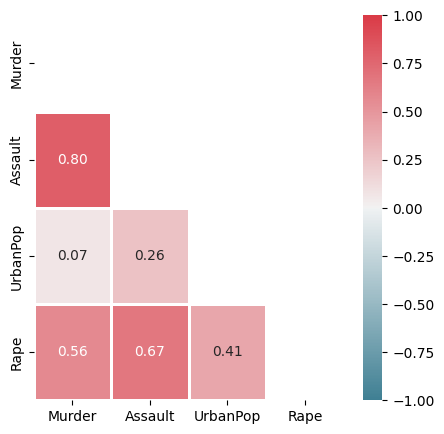

In [409]:
# Generate correlations to plot as colourmap. 
city = df.index
corrs = df.corr()

# Create heatmap of correlations.
colormap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(5, 5))

# Mask mirrored side of heatmap.
dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate heatmap.
ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2, vmin=-1, vmax = 1)
plt.show()

Each of the variables in the dataset is correlated. Assault and murder have a particularly strong correlation. Urban population is more associated with rape than either murder or assault. These correlations suggest that dimension reduction such as PCA may be useful. 

Text(0, 0.5, 'Murder Rate')

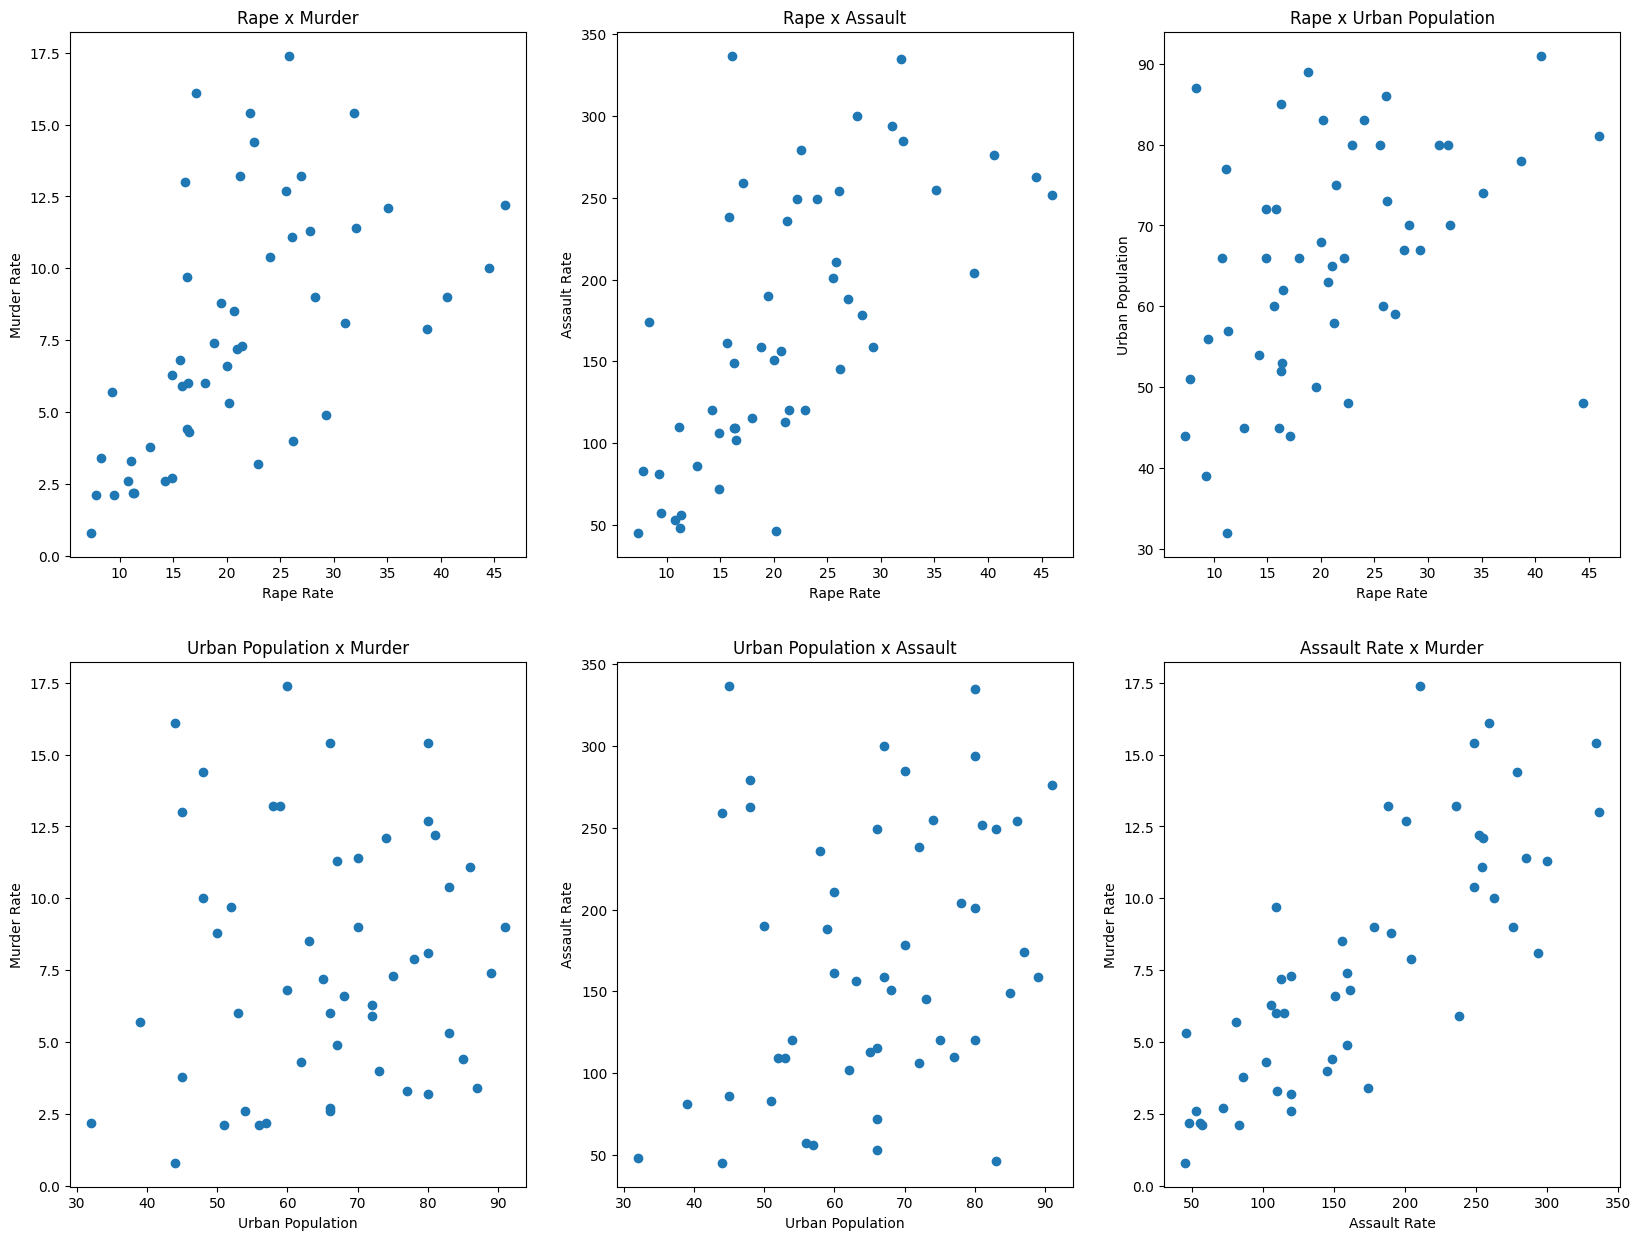

In [410]:
# Plot scatter graphs for each combination of variables.
plt.figure(figsize=[20,15])
plt.subplot(2,3,1)
ax = plt.scatter(df['Rape'], df['Murder'])
plt.title('Rape x Murder')
plt.xlabel('Rape Rate')
plt.ylabel('Murder Rate')

plt.subplot(2,3,2)
ax = plt.scatter(df['Rape'], df['Assault'])
plt.title('Rape x Assault')
plt.xlabel('Rape Rate')
plt.ylabel('Assault Rate')


plt.subplot(2,3,3)
ax = plt.scatter(df['Rape'], df['UrbanPop'])
plt.title('Rape x Urban Population')
plt.xlabel('Rape Rate')
plt.ylabel('Urban Population')

plt.subplot(2,3,4)
ax = plt.scatter(df['UrbanPop'], df['Murder'])
plt.title('Urban Population x Murder')
plt.xlabel('Urban Population')
plt.ylabel('Murder Rate')

plt.subplot(2,3,5)
ax = plt.scatter(df['UrbanPop'], df['Assault'])
plt.title('Urban Population x Assault')
plt.xlabel('Urban Population')
plt.ylabel('Assault Rate')

plt.subplot(2,3,6)
ax = plt.scatter(df['Assault'], df['Murder'])
plt.title('Assault Rate x Murder')
plt.xlabel('Assault Rate')
plt.ylabel('Murder Rate')


These scatter graphs further highlight and visualise the correlations between variables.

# Pre-process data

In [411]:
# Standardise data for PCA.
X_std = StandardScaler().fit_transform(df)

# Perform PCA.
std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

# Create new dataframe. 
df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


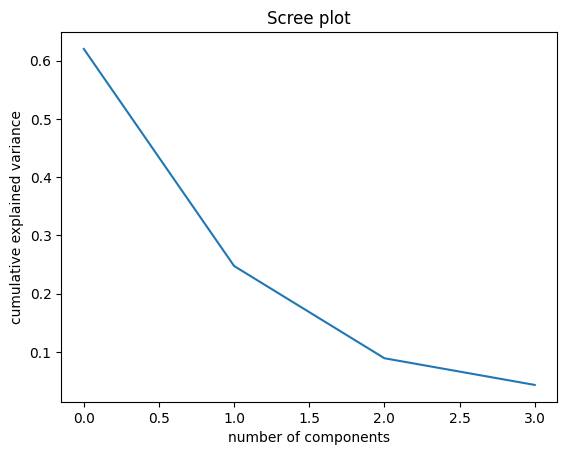

In [413]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

This scree plot shows that 90% of the variance in the data is explained by just two components, so I will continue with PCA with 2 components.

# Conduct Principal Components Analysis

In [428]:
# Choose number of components to be generated.
pca = PCA(n_components=2)

# Obtain components.
principal_components = pca.fit_transform(X_std)

# Transform the components into a pandas data frame.
pca_df = pd.DataFrame(principal_components, index=df.index)

pca_df

,0,1
City,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934
Colorado,1.514563,-0.987555
Connecticut,-1.358647,-1.088928
Delaware,0.047709,-0.325359
Florida,3.013042,0.039229


# 

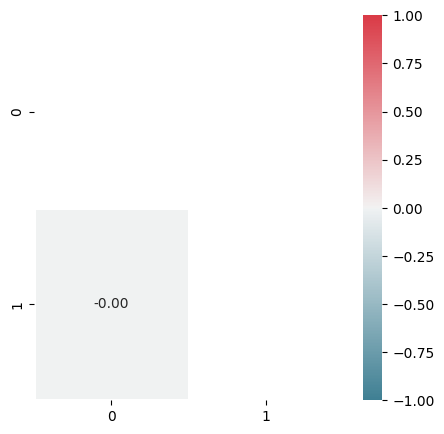

In [435]:
city = pca_df.index
corrs = pca_df.corr()

# Generate correlations to plot as colourmap. 
colormap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(5, 5))

# Mask mirrored side of heatmap.
dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate heatmap.
ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2, vmin=-1, vmax = 1)
plt.show()

This shows that a 2 component PCA produces uncorrelated components. 

In [436]:
# Define function to create biplot. 
def biplot(score, components, ax, coeff,labels=None,points=None):
    xs = score[:,components[0]]
    ys = score[:,components[1]]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = city[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,components[0]], coeff[i,components[1]],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,components[0]]* 1.15, coeff[i,components[1]] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,components[0]]* 1.15, coeff[i,components[1]] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    ax.set_xlabel(f"PC {components[0]+1}")
    ax.set_ylabel(f"PC {components[1]+1}")
    ax.grid()


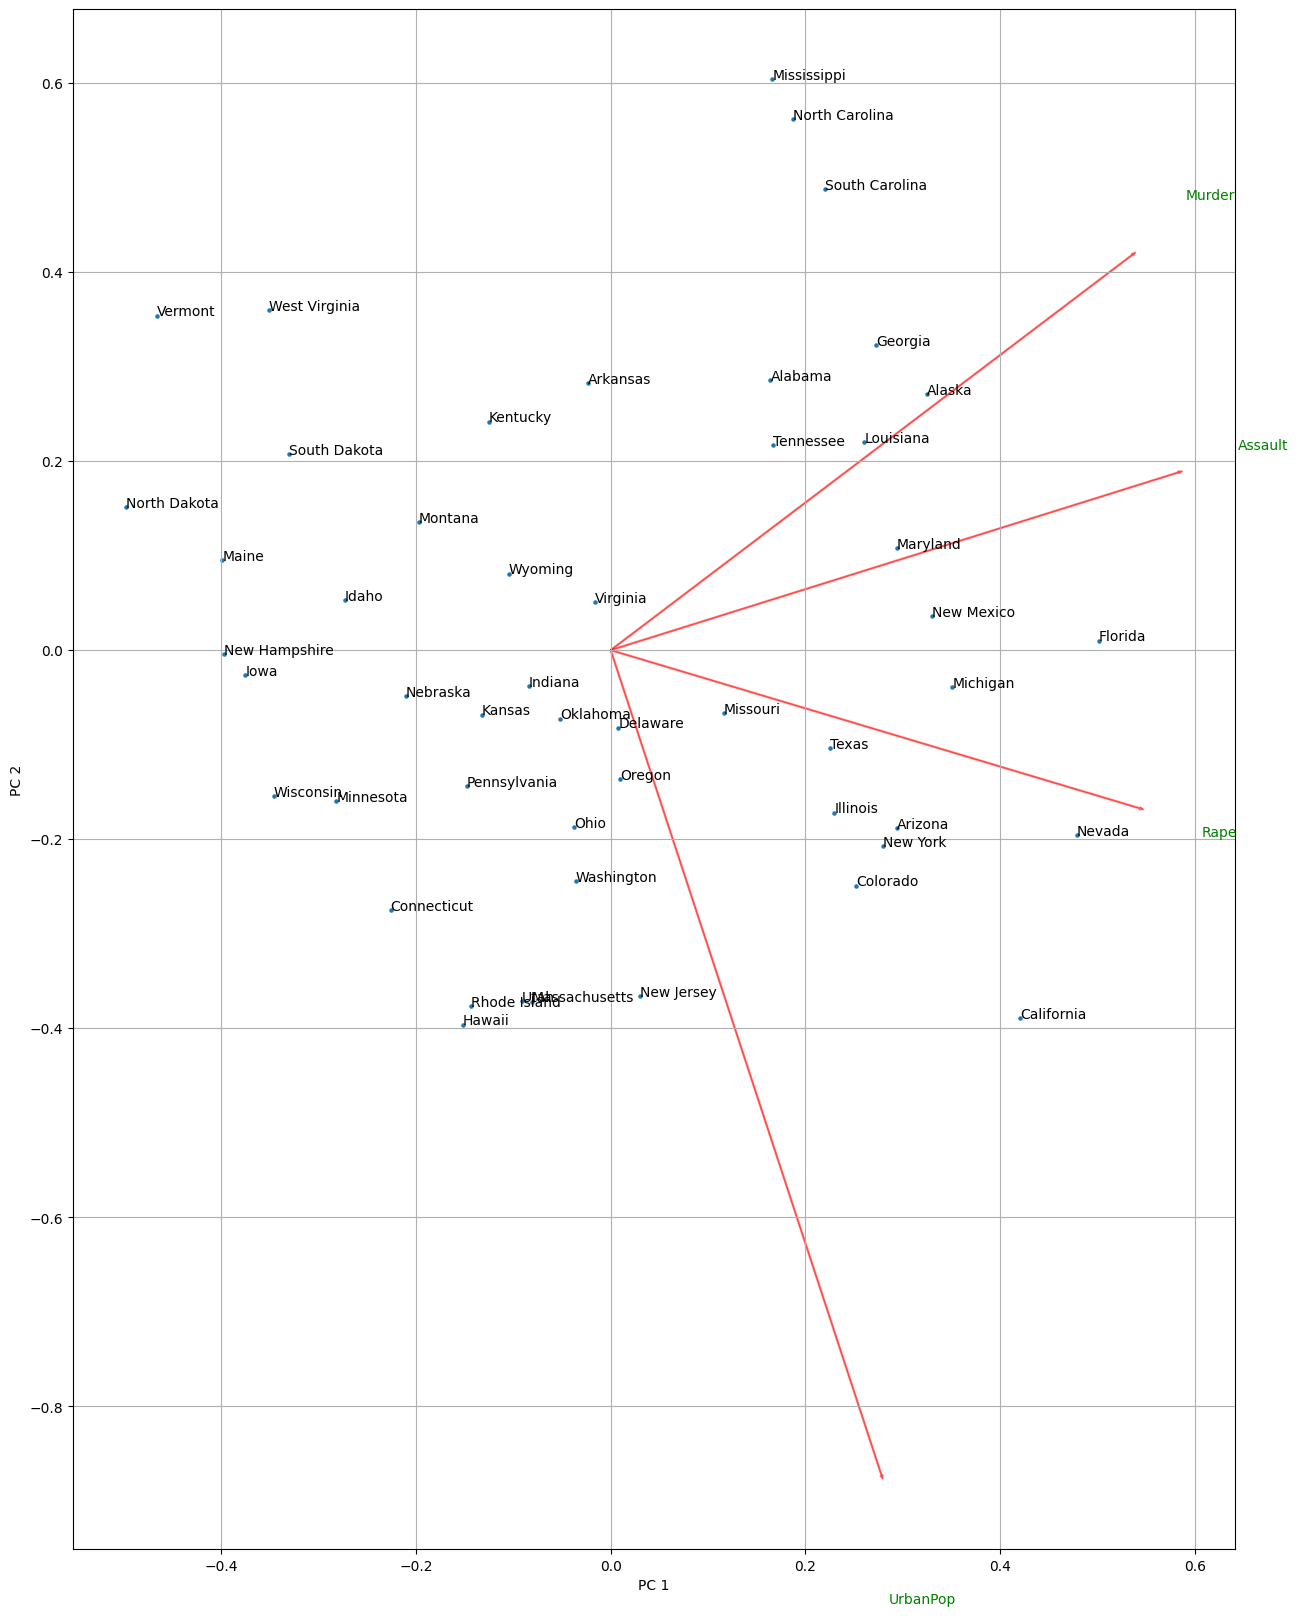

In [447]:
# Create a biplot of the two PCA components.
fig, ax1 = plt.subplots()
fig.set_size_inches(15,20)

biplot(pca_df.values, 
       [0, 1],
       ax1,
       np.transpose(pca.components_), 
       list(df))


# Agglomerative clustering

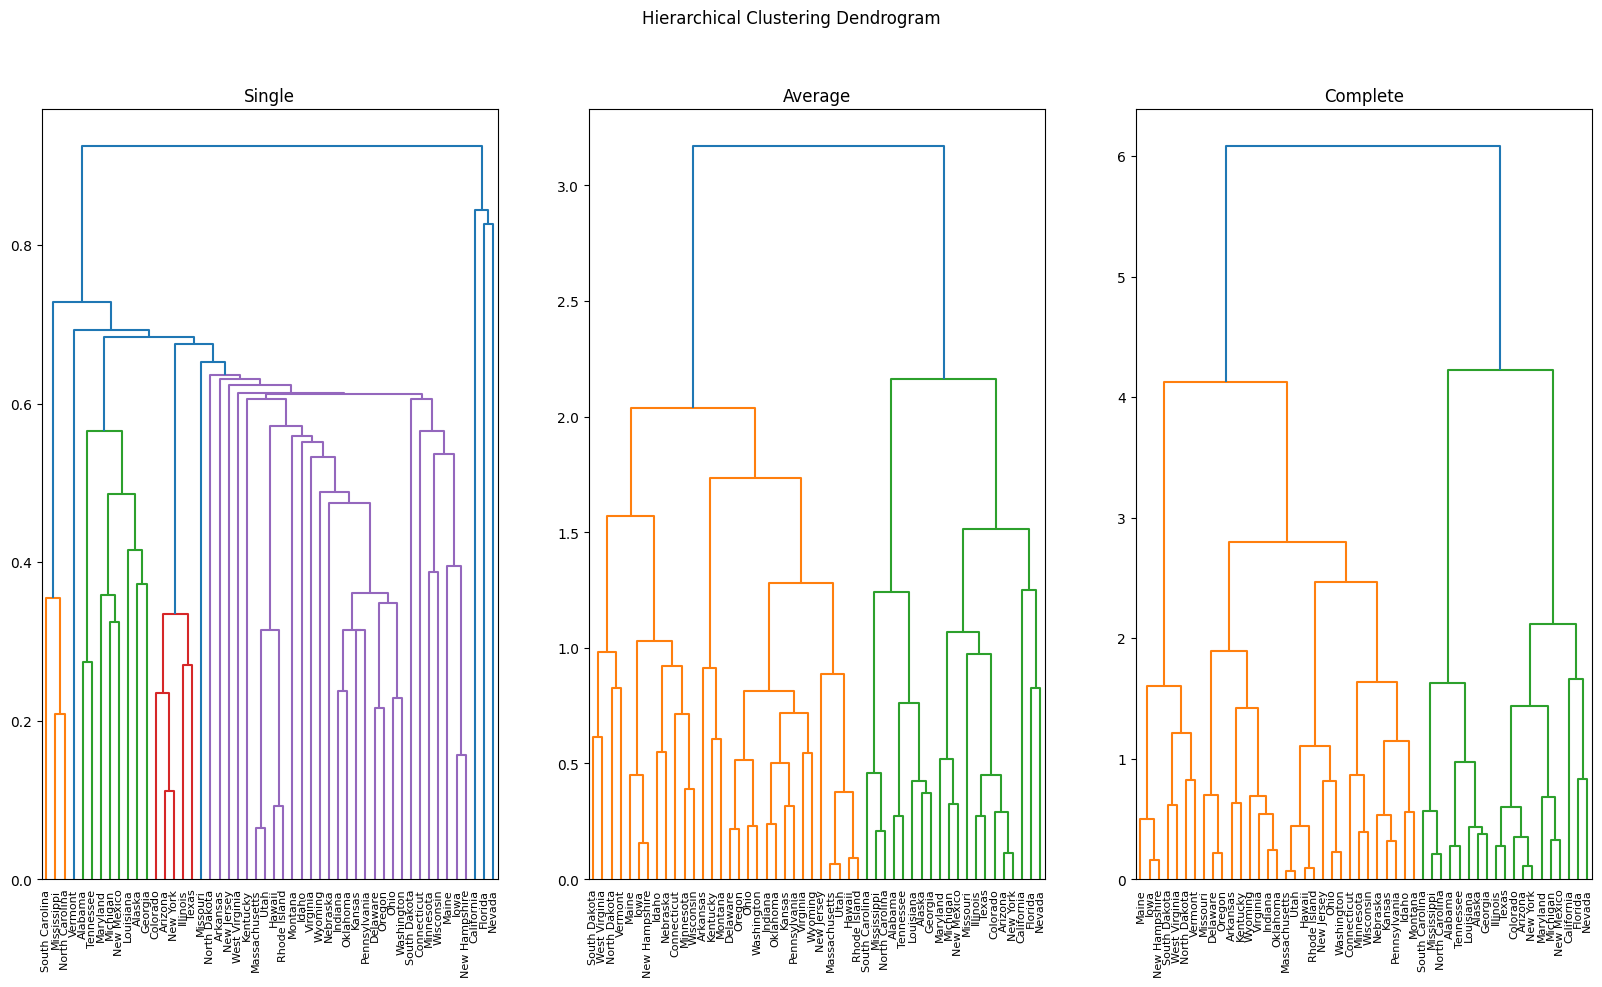

In [448]:
# Create dendograms for clustering.
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
fig.set_size_inches(20,10)
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

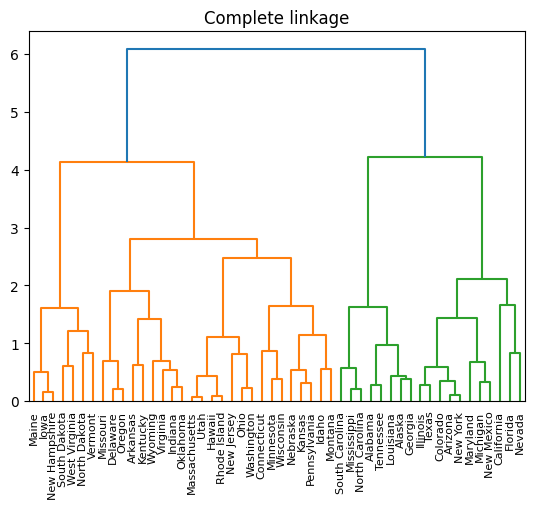

In [449]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

I will continue with a 4 cluster solution as this generates four clusters of reasonable size which are fairly well distinguished from one another.

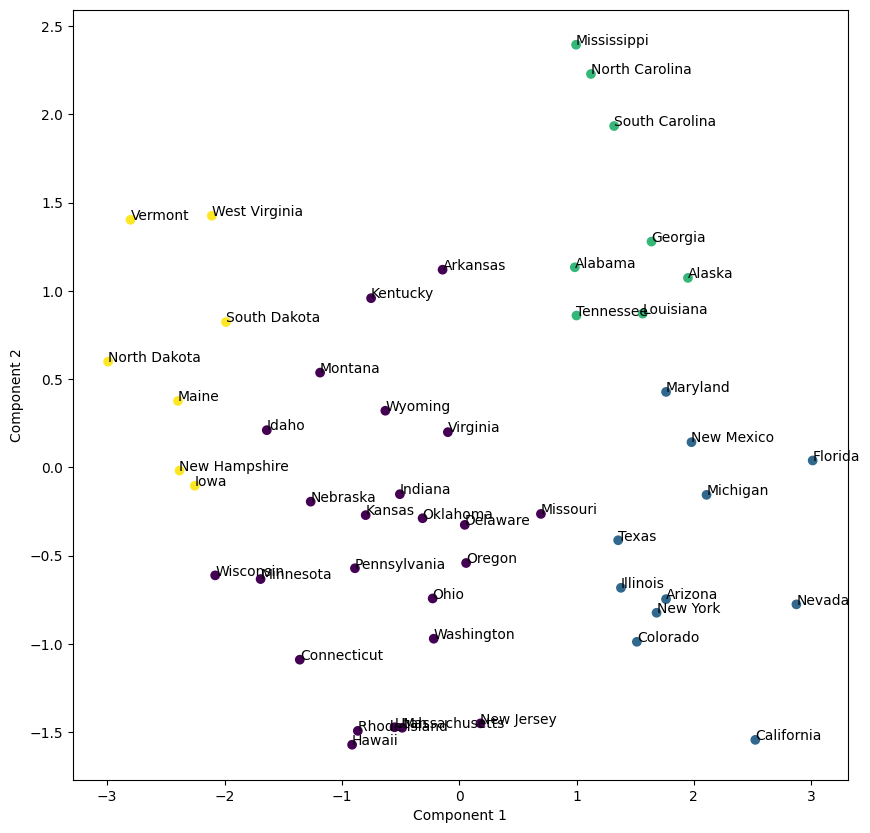

In [457]:
fig, ax1= plt.subplots()
fig.set_size_inches(10,10)

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
cluster.fit_predict(pca_df.values)
ax1.scatter(pca_df.values[:,0], pca_df.values[:,1], c=cluster.labels_)
for i in range(0,len(pca_df.values)):
    txt = city[i]
    ax1.annotate(txt, (pca_df.values[:,0][i], pca_df.values[:,1][i]))
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')

plt.show()


In [463]:
df['Agglomerative Clusters'] = cluster.labels_
print(df.groupby(by='Agglomerative Clusters').mean().iloc[:,0:4])
print(df.groupby(by='Agglomerative Clusters').count().iloc[:,0:4])

                           Murder     Assault   UrbanPop       Rape
Agglomerative Clusters                                             
0                        5.675000  131.458333  68.958333  18.220833
1                       11.054545  264.090909  79.090909  32.618182
2                       14.087500  252.750000  53.500000  24.537500
3                        2.700000   65.142857  46.285714   9.885714
                        Murder  Assault  UrbanPop  Rape
Agglomerative Clusters                                 
0                           24       24        24    24
1                           11       11        11    11
2                            8        8         8     8
3                            7        7         7     7


# Interpretation

Text(0, 0.5, 'Murder Rate')

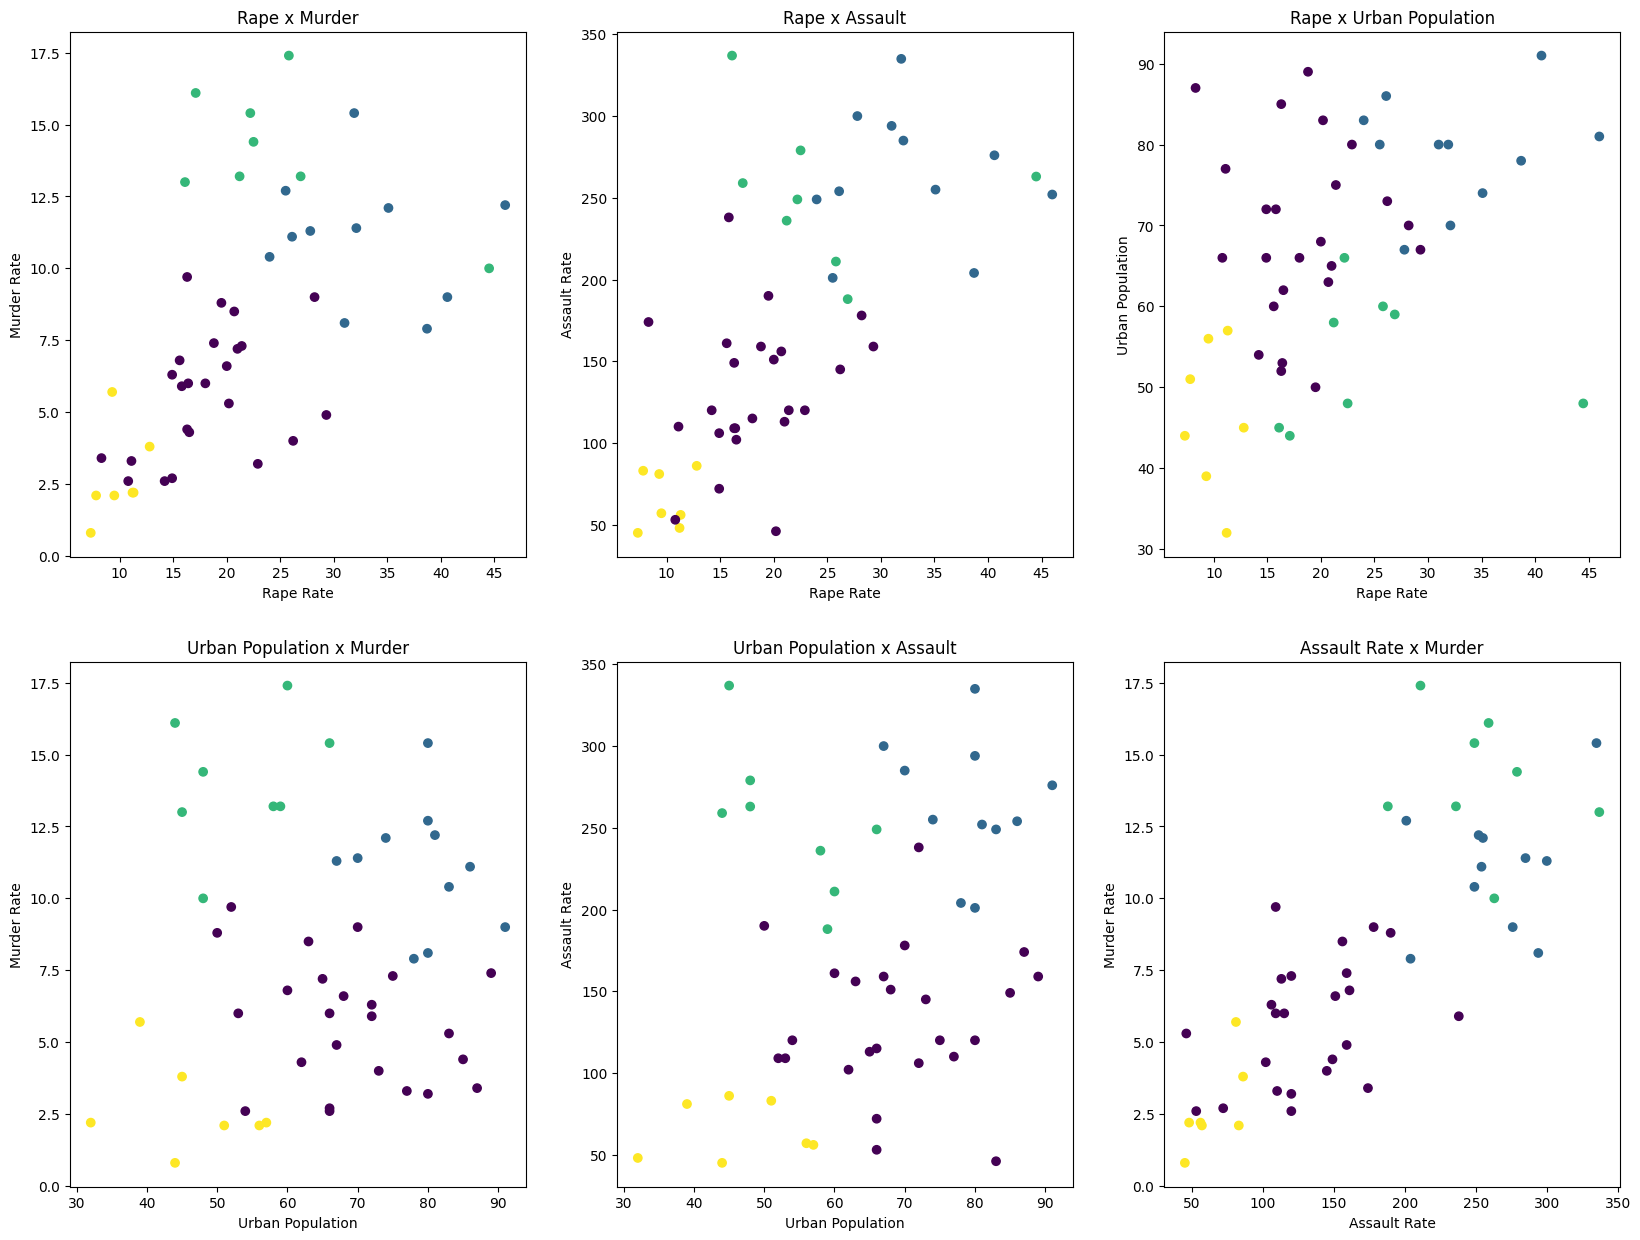

In [464]:
# Plot scatter graphs for each variable combination. 
plt.figure(figsize=[20,15])
plt.subplot(2,3,1)
ax = plt.scatter(df['Rape'], df['Murder'], c=cluster.labels_)
plt.title('Rape x Murder')
plt.xlabel('Rape Rate')
plt.ylabel('Murder Rate')

plt.subplot(2,3,2)
ax = plt.scatter(df['Rape'], df['Assault'], c=cluster.labels_)
plt.title('Rape x Assault')
plt.xlabel('Rape Rate')
plt.ylabel('Assault Rate')


plt.subplot(2,3,3)
ax = plt.scatter(df['Rape'], df['UrbanPop'], c=cluster.labels_)
plt.title('Rape x Urban Population')
plt.xlabel('Rape Rate')
plt.ylabel('Urban Population')


plt.subplot(2,3,4)
ax = plt.scatter(df['UrbanPop'], df['Murder'], c=cluster.labels_)
plt.title('Urban Population x Murder')
plt.xlabel('Urban Population')
plt.ylabel('Murder Rate')

plt.subplot(2,3,5)
ax = plt.scatter(df['UrbanPop'], df['Assault'], c=cluster.labels_)
plt.title('Urban Population x Assault')
plt.xlabel('Urban Population')
plt.ylabel('Assault Rate')

plt.subplot(2,3,6)
ax = plt.scatter(df['Assault'], df['Murder'], c=cluster.labels_)
plt.title('Assault Rate x Murder')
plt.xlabel('Assault Rate')
plt.ylabel('Murder Rate')


Cluster 0 (Purple): Most states fall into this cluster. It has relatively low (but not the lowest) rates of all 3 types of crime  despite a fairly high urban population.

Cluster 1 (Blue): Has a high urban population and high levels of rape, but lower levels of murder and assault than cluster 2. 

Cluster 2 (Green): Has a lower urban population and lower levels of rape than cluster 2, but high levels of murder and assault. 

Cluster 3 (Yellow): Has markedly lower urban population and low rates of all 3 types of crime.It is characterised by being in the lower left corner of all scatter graphs (low rates of everything)

# K-Means Clustering

Text(0, 0.5, 'Dim 2')

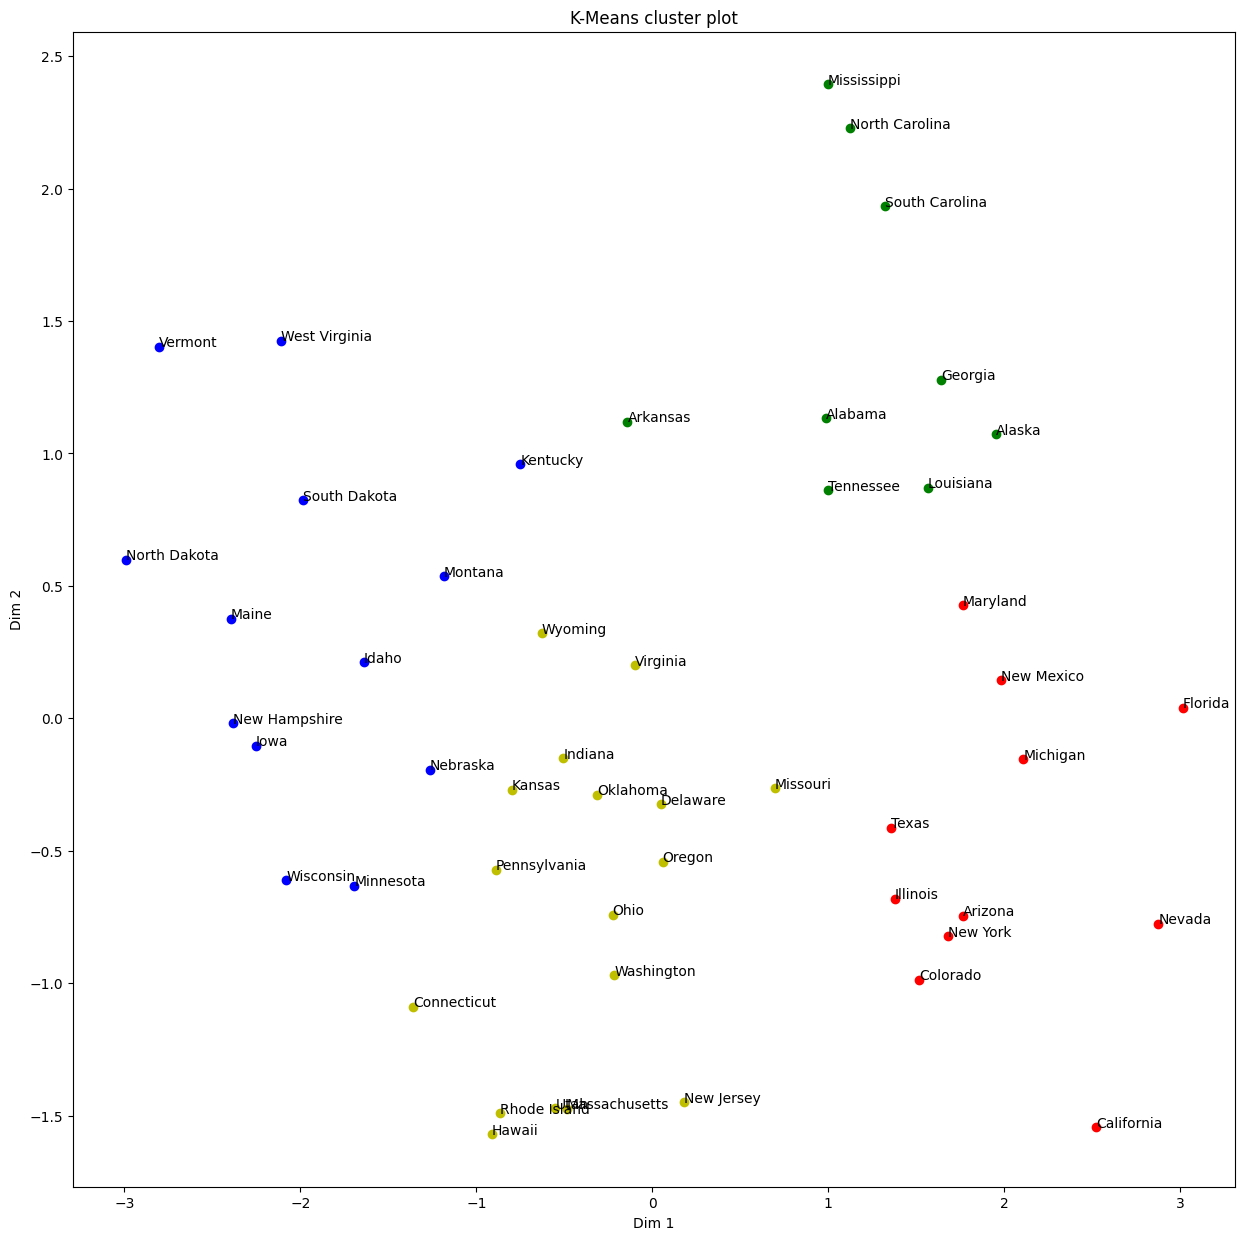

In [468]:
from sklearn.cluster import KMeans

# We extract the first two components
dim1 = X_std_trans[:,0]
dim2 = X_std_trans[:,1]
dim3 = X_std_trans[:,2]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax1 = plt.subplots(1)
fig.set_size_inches(15,15)
colours = 'rbgy'

for i in range(0,k):
    ax1.scatter(dim1[cluster_labels == i],dim2[cluster_labels == i],c = colours[i]) 
for i in range(0,len(dim1)):
        txt = city[i]
        ax1.annotate(txt, (dim1[i], dim2[i]))
ax1.set_title("K-Means cluster plot")
ax1.set_xlabel("Dim 1")
ax1.set_ylabel("Dim 2")


In [469]:
df['K-Clusters'] = cluster_labels
print(df.groupby(by="K-Clusters").mean().iloc[:,0:4])
print(df.groupby(by="K-Clusters").count().iloc[:,0:4])

               Murder     Assault   UrbanPop       Rape
K-Clusters                                             
0           11.054545  264.090909  79.090909  32.618182
1            3.600000   78.538462  52.076923  12.176923
2           13.500000  245.777778  53.111111  23.977778
3            5.852941  141.176471  73.647059  19.335294
            Murder  Assault  UrbanPop  Rape
K-Clusters                                 
0               11       11        11    11
1               13       13        13    13
2                9        9         9     9
3               17       17        17    17


Text(0, 0.5, 'Murder Rate')

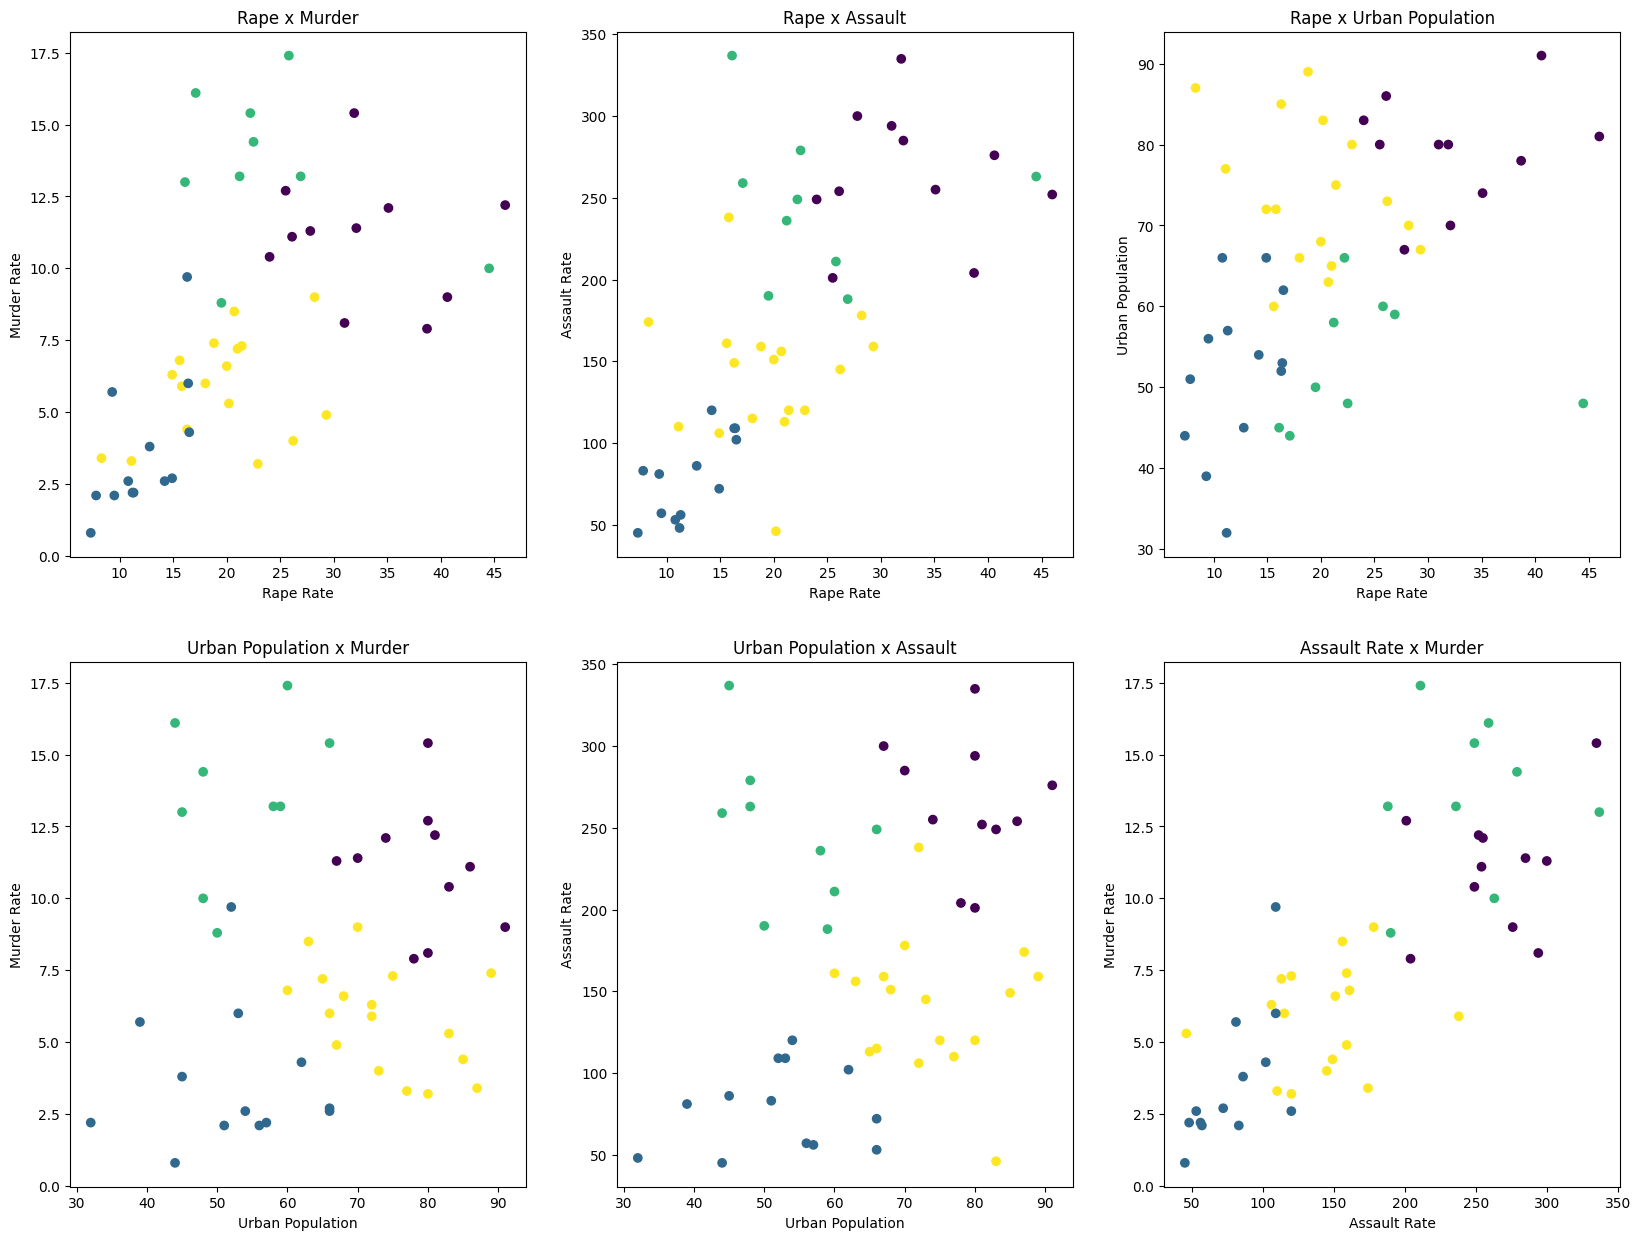

In [470]:
# Plot scatter graphs for each model.
plt.figure(figsize=[20,15])
plt.subplot(2,3,1)
ax = plt.scatter(df['Rape'], df['Murder'], c=cluster_labels)
plt.title('Rape x Murder')
plt.xlabel('Rape Rate')
plt.ylabel('Murder Rate')

plt.subplot(2,3,2)
ax = plt.scatter(df['Rape'], df['Assault'], c=cluster_labels)
plt.title('Rape x Assault')
plt.xlabel('Rape Rate')
plt.ylabel('Assault Rate')


plt.subplot(2,3,3)
ax = plt.scatter(df['Rape'], df['UrbanPop'], c=cluster_labels)
plt.title('Rape x Urban Population')
plt.xlabel('Rape Rate')
plt.ylabel('Urban Population')


plt.subplot(2,3,4)
ax = plt.scatter(df['UrbanPop'], df['Murder'], c=cluster_labels)
plt.title('Urban Population x Murder')
plt.xlabel('Urban Population')
plt.ylabel('Murder Rate')

plt.subplot(2,3,5)
ax = plt.scatter(df['UrbanPop'], df['Assault'], c=cluster_labels)
plt.title('Urban Population x Assault')
plt.xlabel('Urban Population')
plt.ylabel('Assault Rate')

plt.subplot(2,3,6)
ax = plt.scatter(df['Assault'], df['Murder'], c=cluster_labels)
plt.title('Assault Rate x Murder')
plt.xlabel('Assault Rate')
plt.ylabel('Murder Rate')


Cluster 0 (Purple): This cluster contains states with a high urban population and high levels of rape, but lower levels of murder and assault than cluster 2.

Cluster 1 (Blue): This cluster has a low urban population level as well as markedly lower rates of all types of violent crime.

Cluster 2 (Green): This cluster is characterised by low levels of urban population and rape, but the highest levels of assault and murder.

Cluster 3 (Yellow): This cluster includes states with a high urban population but low levels of each type of violent crime (though not as low as cluster 1.)

# Conclusions

Both types of clustering performed well on the data after application of PCA. Whilst the clusters produced were somewhat different, there were similarities - e.g. both produced a cluster with low urban population and low violent crime, and both produced a cluster with high urban population and high levels of assault and murder. Both also produced a cluster with relatively high urban population but lower crime levels. Either of these clustering measures would likely provide useful predictive value and were interpretable. 